In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from gensim.models import Word2Vec
from catboost import CatBoostClassifier

import nltk
from nltk import word_tokenize
nltk.download('stopwords')
from nltk.tokenize import RegexpTokenizer
from nltk.util import ngrams

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dabannikov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Dataset

In [157]:
cat = pd.read_csv('./data/categories.csv')

In [158]:
prod = pd.read_csv('./data/products.csv')

## Validation

In [159]:
cat.head()

,category_id,category_title,category_path
0,13021,Базы и топы,1.10012.10113.13021
1,2740,Полки и подставки,1.10018.10110.12842.2740
2,13182,Салюты,1.10018.10118.10749.13182
3,2864,Ложки для обуви,1.10018.10110.12823.2864
4,14154,Аромабудильники и картриджи,1.10020.10227.14154


In [160]:
prod.head()

,row_number,product_title,category_id
0,1,Термокружка с животными 350/500 мл,12407
1,2,Пластиковая емкость для хранения круп,12667
2,3,Контейнер с дозатором для хранения круп,13901
3,4,Контейнер для хранения яиц,13674
4,5,Губкодержатель,13254


In [161]:
cat.shape, prod.shape

((959, 3), (144082, 3))

In [162]:
prod['row_number'].shape[0] - prod['row_number'].unique().shape[0]

0

In [163]:
cat['category_id'].shape[0] - cat['category_id'].unique().shape[0]

0

## Feature Extraction

Количесво категорий - классов

In [164]:
prod.category_id.unique().shape

(787,)

In [165]:
categories =  {row['category_id']:row['category_path'] for _, row in cat.iterrows()}

In [166]:
prod['full_category'] = prod['category_id'].apply(lambda cat_id: categories[cat_id])

In [167]:
prod['category_0'] = prod['full_category'].apply(lambda full_cat: full_cat.split('.')[0])
prod['category_1'] = prod['full_category'].apply(lambda full_cat: full_cat.split('.')[1])
prod['category_2'] = prod['full_category'].apply(lambda full_cat: full_cat.split('.')[2])
prod['category_3'] = prod['full_category'].apply(lambda full_cat: full_cat.split('.')[3])
prod['category_4'] = prod['full_category'].apply(lambda full_cat: full_cat.split('.')[4] if len(full_cat.split('.')) > 4 else np.nan)

In [181]:
cat['category_0'] = cat['category_path'].apply(lambda full_cat: full_cat.split('.')[0])
cat['category_1'] = cat['category_path'].apply(lambda full_cat: full_cat.split('.')[1])
cat['category_2'] = cat['category_path'].apply(lambda full_cat: full_cat.split('.')[2]  if len(full_cat.split('.')) > 2 else np.nan)

In [108]:
prod['category_0'].unique().shape, prod['category_1'].unique().shape, prod['category_2'].unique().shape, prod['category_3'].unique().shape, prod['category_4'].unique().shape

((1,), (3,), (37,), (239,), (639,))

In [109]:
prod.head(7)

,row_number,product_title,category_id,full_category,category_0,category_1,category_2,category_3,category_4
0,1,Термокружка с животными 350/500 мл,12407,1.10018.10115.10586.12407,1,10018,10115,10586,12407
1,2,Пластиковая емкость для хранения круп,12667,1.10018.10115.10992.12667,1,10018,10115,10992,12667
2,3,Контейнер с дозатором для хранения круп,13901,1.10018.10115.10992.13901,1,10018,10115,10992,13901
3,4,Контейнер для хранения яиц,13674,1.10018.10115.10992.13674,1,10018,10115,10992,13674
4,5,Губкодержатель,13254,1.10018.10115.10390.13254,1,10018,10115,10390,13254
5,6,Глубокая тарелка для овощей,11999,1.10018.10115.10377.11999,1,10018,10115,10377,11999
6,7,Держатель на кухонный гарнитур под отходы,14095,1.10018.10110.14095,1,10018,10110,14095,NaN


In [16]:
prod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144082 entries, 0 to 144081
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   row_number     144082 non-null  int64 
 1   product_title  144082 non-null  object
 2   category_id    144082 non-null  int64 
 3   full_category  144082 non-null  object
 4   category_0     144082 non-null  object
 5   category_1     144082 non-null  object
 6   category_2     144082 non-null  object
 7   category_3     144082 non-null  object
 8   category_4     116099 non-null  object
dtypes: int64(2), object(7)
memory usage: 9.9+ MB


In [17]:
def tokenize(text):
    stopwords_rus = nltk.corpus.stopwords.words('russian')
    tokeniser = RegexpTokenizer("[A-Za-zА-Яа-я]+")
    tokens = tokeniser.tokenize(text)
    
    tokens_lower = [t.lower() for t in tokens]
    tokens_clean = [t for t in tokens_lower if t not in stopwords_rus]
    return ' '.join(tokens_clean)

In [18]:
%%time
prod['preproc'] = prod['product_title'].apply(tokenize)

CPU times: user 14.6 s, sys: 3.13 s, total: 17.8 s
Wall time: 17.8 s


In [19]:
prod.head()

,row_number,product_title,category_id,full_category,category_0,category_1,category_2,category_3,category_4,preproc
0,1,Термокружка с животными 350/500 мл,12407,1.10018.10115.10586.12407,1,10018,10115,10586,12407,термокружка животными мл
1,2,Пластиковая емкость для хранения круп,12667,1.10018.10115.10992.12667,1,10018,10115,10992,12667,пластиковая емкость хранения круп
2,3,Контейнер с дозатором для хранения круп,13901,1.10018.10115.10992.13901,1,10018,10115,10992,13901,контейнер дозатором хранения круп
3,4,Контейнер для хранения яиц,13674,1.10018.10115.10992.13674,1,10018,10115,10992,13674,контейнер хранения яиц
4,5,Губкодержатель,13254,1.10018.10115.10390.13254,1,10018,10115,10390,13254,губкодержатель


На больших трех категориях объекты расположились практически хорошо.

<AxesSubplot:xlabel='category_1', ylabel='Count'>

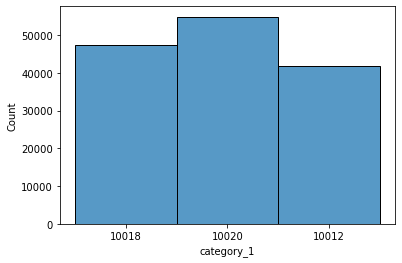

In [20]:
sns.histplot(prod['category_1'])

Вторая категория имеет больше трети малочисленных класса и один класс к которому относиться чуть меньше трети объектов.

<AxesSubplot:xlabel='category_2', ylabel='Count'>

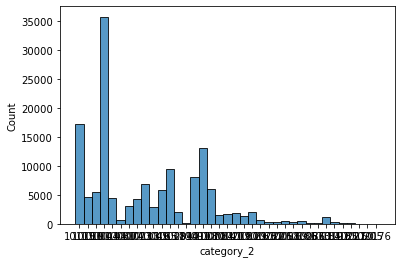

In [21]:
sns.histplot(prod['category_2'])

Классы этой группы категорий практически сбалансированные

## Feature generagion

In [22]:
%%time
w2v = Word2Vec(min_count=5, window=2, vector_size=50, sample=6e-5, alpha=0.03, min_alpha=0.0007, negative=10, seed=17)
w2v.build_vocab(prod['preproc'].apply(lambda x: x.split()), progress_per=1000)
w2v.train(prod['preproc'].apply(lambda x: x.split()), total_examples=w2v.corpus_count, epochs=60, report_delay=1)

CPU times: user 1min, sys: 319 ms, total: 1min 1s
Wall time: 22.4 s


(26303998, 52935300)

Усредняем векторы word2veс и получаем вектор предожения

In [23]:
%%time
vect = prod['preproc'].apply(lambda text: np.mean([w2v.wv[w] for w in text.split() if w in w2v.wv], axis=0))

/Users/dabannikov/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


CPU times: user 3.75 s, sys: 20.6 ms, total: 3.77 s
Wall time: 3.77 s


In [201]:
y = prod['category_1'][vect.notna()]
y_cat_2 = prod['category_2'][vect.notna()]
y_cat_3 = prod['category_3'][vect.notna()]
X = vect[vect.notna()]
X = np.stack(X)

In [202]:
level1_categories = prod[vect.notna()]['category_1'].values

In [203]:
level1_categories = level1_categories.reshape(-1, 1)

In [204]:
extnd_X = np.hstack([X, level1_categories])

In [205]:
extnd_X

array([[0.25680842995643616, 0.552771270275116, 0.5704972147941589, ...,
        0.5262089371681213, 0.5139042735099792, '10018'],
       [0.010040469467639923, -0.33369529247283936, -0.6273865103721619,
        ..., 0.09674374014139175, 1.0678973197937012, '10018'],
       [0.0063163116574287415, -0.6553321480751038, -0.7335885167121887,
        ..., 0.0923047810792923, 0.5021090507507324, '10018'],
       ...,
       [-1.3494764566421509, 0.1847909390926361, -0.257911741733551, ...,
        -0.16615377366542816, 0.4530147910118103, '10020'],
       [-1.0240410566329956, -2.077448844909668, 0.2313496172428131, ...,
        -1.2313446998596191, 0.40049099922180176, '10018'],
       [-0.0413561575114727, 0.1419793963432312, 0.5433689951896667, ...,
        0.31827646493911743, 0.7836732268333435, '10020']], dtype=object)

In [29]:
len(prod['category_2'].unique())

37

### Кросс валидация на таргете с 3 большими категориями. Mean accuracy ~ 0.98, mean f1_micro ~ 0.98, mean f1_macro ~ 0.979

In [55]:
%%time
model = CatBoostClassifier(random_seed=17, depth=6, learning_rate=0.5, thread_count=4, loss_function='MultiClass', custom_metric='TotalF1', eval_metric='TotalF1')
result = pd.DataFrame(cross_validate(model, X, y, cv=4, 
    scoring=['accuracy', 'f1_micro', 'f1_macro', 'f1_weighted'], n_jobs=-1))
mean = result.mean().rename('{}_mean'.format)
std = result.std().rename('{}_std'.format)
results = pd.concat([mean[2:], std[2:]], axis=0)

CPU times: user 394 ms, sys: 143 ms, total: 537 ms
Wall time: 1min 58s


In [56]:
results

test_accuracy_mean       0.980402
test_f1_micro_mean       0.980402
test_f1_macro_mean       0.979770
test_f1_weighted_mean    0.980409
test_accuracy_std        0.002054
test_f1_micro_std        0.002054
test_f1_macro_std        0.002059
test_f1_weighted_std     0.002053
dtype: float64

### Кросс валидация на таргете с 37 категориями, без добавления в качестве признака таргет с прошлого уровня категорий (с 3 категориями). Mean accuracy ~ 0.826, mean f1_micro ~ 0.826, mean f1_macro ~ 0.618

In [57]:
%%time
model = CatBoostClassifier(random_seed=17, depth=6, learning_rate=0.5, thread_count=4, loss_function='MultiClass', custom_metric='TotalF1', eval_metric='TotalF1')
result = pd.DataFrame(cross_validate(model, X, y_cat_2, cv=4, 
    scoring=['accuracy', 'f1_micro', 'f1_macro', 'f1_weighted'], n_jobs=-1))
mean = result.mean().rename('{}_mean'.format)
std = result.std().rename('{}_std'.format)
results = pd.concat([mean[2:], std[2:]], axis=0)

CPU times: user 495 ms, sys: 93.7 ms, total: 588 ms
Wall time: 48min 32s


In [58]:
results

test_accuracy_mean       0.828590
test_f1_micro_mean       0.828590
test_f1_macro_mean       0.640206
test_f1_weighted_mean    0.828450
test_accuracy_std        0.007131
test_f1_micro_std        0.007131
test_f1_macro_std        0.021823
test_f1_weighted_std     0.006176
dtype: float64

### Кросс валидация на таргете с 37 категориями, c добавления в качестве признака таргет с прошлого уровня категорий (с 3 категориями). Mean accuracy ~ 0.827, mean f1_micro ~ 0.827, mean f1_macro ~ 0.617

In [206]:
%%time
model = CatBoostClassifier(random_seed=17, depth=6, learning_rate=0.5, thread_count=4, loss_function='MultiClass', custom_metric='TotalF1', eval_metric='TotalF1')
result = pd.DataFrame(cross_validate(model, StandardScaler().fit_transform(extnd_X), y_cat_2, cv=4, 
    scoring=['accuracy', 'f1_micro', 'f1_macro', 'f1_weighted'], n_jobs=-1))
mean = result.mean().rename('{}_mean'.format)
std = result.std().rename('{}_std'.format)
results = pd.concat([mean[2:], std[2:]], axis=0)

CPU times: user 971 ms, sys: 295 ms, total: 1.27 s
Wall time: 55min 53s


In [207]:
results

test_accuracy_mean       0.839132
test_f1_micro_mean       0.839132
test_f1_macro_mean       0.657218
test_f1_weighted_mean    0.838983
test_accuracy_std        0.006315
test_f1_micro_std        0.006315
test_f1_macro_std        0.025047
test_f1_weighted_std     0.005678
dtype: float64

In [208]:
# %%time
# params = {'depth':[i for i in range(5, 10)],
# 'learning_rate':np.linspace(0.01, 0.5, 10).tolist(),
# 'l2_leaf_reg':[1, 3, 5, 7, 9]}
# params
# model = CatBoostClassifier(thread_count=4, loss_function='MultiClass', custom_metric='TotalF1', eval_metric='TotalF1')
# result = model.grid_search(X=X, y=y, param_grid=params, cv=4, plot=True, partition_random_seed=17, calc_cv_statistics=True,
#         search_by_train_test_split=True, refit=True, shuffle=True, stratified=None, train_size=0.8, verbose=True)

### Кросс валидация на таргете с 239 категориями, без добавления в качестве признаков таргетов с прошлых уровней категорий (с 3 и 37 категориями). mean f1_macro ~ 0.26

In [209]:
%%time
model = CatBoostClassifier(random_seed=17, depth=6, learning_rate=0.5, thread_count=4, loss_function='MultiClass', custom_metric='TotalF1', eval_metric='TotalF1')
result = pd.DataFrame(cross_validate(model, X, y_cat_3, cv=4, 
    scoring=['accuracy', 'f1_micro', 'f1_macro', 'f1_weighted'], n_jobs=-1))
mean = result.mean().rename('{}_mean'.format)
std = result.std().rename('{}_std'.format)
results = pd.concat([mean[2:], std[2:]], axis=0)

/Users/dabannikov/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"


KeyboardInterrupt: 

In [210]:
results

test_accuracy_mean       0.839132
test_f1_micro_mean       0.839132
test_f1_macro_mean       0.657218
test_f1_weighted_mean    0.838983
test_accuracy_std        0.006315
test_f1_micro_std        0.006315
test_f1_macro_std        0.025047
test_f1_weighted_std     0.005678
dtype: float64

In [59]:
%%time
model = CatBoostClassifier(random_seed=17, depth=6, learning_rate=0.5, thread_count=4, loss_function='MultiClass', custom_metric='TotalF1', eval_metric='TotalF1')
model.fit(StandardScaler().fit_transform(X), y_cat_2)

0:	learn: 0.4482109	total: 1.15s	remaining: 19m 7s
1:	learn: 0.1534236	total: 2.18s	remaining: 18m 10s
2:	learn: 0.3661573	total: 3.17s	remaining: 17m 33s
3:	learn: 0.2851727	total: 4.17s	remaining: 17m 17s
4:	learn: 0.4329102	total: 5.17s	remaining: 17m 8s
5:	learn: 0.4465954	total: 6.17s	remaining: 17m 1s
6:	learn: 0.4578045	total: 7.14s	remaining: 16m 53s
7:	learn: 0.4640782	total: 8.1s	remaining: 16m 43s
8:	learn: 0.4401253	total: 9.11s	remaining: 16m 43s
9:	learn: 0.4751715	total: 10.2s	remaining: 16m 50s
10:	learn: 0.4729297	total: 11.3s	remaining: 16m 56s
11:	learn: 0.5010406	total: 12.6s	remaining: 17m 14s
12:	learn: 0.5155836	total: 13.7s	remaining: 17m 21s
13:	learn: 0.5390526	total: 14.8s	remaining: 17m 25s
14:	learn: 0.5548139	total: 15.9s	remaining: 17m 25s
15:	learn: 0.5671936	total: 17s	remaining: 17m 28s
16:	learn: 0.5850508	total: 18.1s	remaining: 17m 25s
17:	learn: 0.5975582	total: 19.1s	remaining: 17m 23s
18:	learn: 0.6061999	total: 20.2s	remaining: 17m 23s
19:	learn

154:	learn: 0.7740217	total: 2m 45s	remaining: 14m 59s
155:	learn: 0.7741598	total: 2m 46s	remaining: 14m 58s
156:	learn: 0.7750891	total: 2m 47s	remaining: 14m 57s
157:	learn: 0.7755645	total: 2m 48s	remaining: 14m 56s
158:	learn: 0.7767946	total: 2m 49s	remaining: 14m 54s
159:	learn: 0.7755374	total: 2m 50s	remaining: 14m 53s
160:	learn: 0.7759500	total: 2m 51s	remaining: 14m 52s
161:	learn: 0.7754888	total: 2m 52s	remaining: 14m 50s
162:	learn: 0.7775551	total: 2m 53s	remaining: 14m 49s
163:	learn: 0.7780044	total: 2m 54s	remaining: 14m 48s
164:	learn: 0.7781914	total: 2m 55s	remaining: 14m 46s
165:	learn: 0.7785815	total: 2m 56s	remaining: 14m 46s
166:	learn: 0.7795927	total: 2m 57s	remaining: 14m 44s
167:	learn: 0.7796922	total: 2m 58s	remaining: 14m 43s
168:	learn: 0.7807462	total: 2m 59s	remaining: 14m 42s
169:	learn: 0.7820972	total: 3m	remaining: 14m 41s
170:	learn: 0.7826543	total: 3m 1s	remaining: 14m 40s
171:	learn: 0.7831916	total: 3m 2s	remaining: 14m 39s
172:	learn: 0.78

305:	learn: 0.8346077	total: 5m 27s	remaining: 12m 22s
306:	learn: 0.8345977	total: 5m 28s	remaining: 12m 21s
307:	learn: 0.8350378	total: 5m 29s	remaining: 12m 20s
308:	learn: 0.8349094	total: 5m 30s	remaining: 12m 19s
309:	learn: 0.8347600	total: 5m 31s	remaining: 12m 18s
310:	learn: 0.8350568	total: 5m 32s	remaining: 12m 16s
311:	learn: 0.8356306	total: 5m 33s	remaining: 12m 15s
312:	learn: 0.8361695	total: 5m 34s	remaining: 12m 14s
313:	learn: 0.8360760	total: 5m 35s	remaining: 12m 13s
314:	learn: 0.8360063	total: 5m 36s	remaining: 12m 12s
315:	learn: 0.8362565	total: 5m 37s	remaining: 12m 11s
316:	learn: 0.8366757	total: 5m 38s	remaining: 12m 10s
317:	learn: 0.8372971	total: 5m 39s	remaining: 12m 9s
318:	learn: 0.8375890	total: 5m 40s	remaining: 12m 7s
319:	learn: 0.8369550	total: 5m 42s	remaining: 12m 6s
320:	learn: 0.8371444	total: 5m 43s	remaining: 12m 5s
321:	learn: 0.8372206	total: 5m 44s	remaining: 12m 4s
322:	learn: 0.8377438	total: 5m 45s	remaining: 12m 4s
323:	learn: 0.83

456:	learn: 0.8602663	total: 8m 13s	remaining: 9m 45s
457:	learn: 0.8603605	total: 8m 14s	remaining: 9m 44s
458:	learn: 0.8605394	total: 8m 15s	remaining: 9m 43s
459:	learn: 0.8606019	total: 8m 16s	remaining: 9m 42s
460:	learn: 0.8608783	total: 8m 17s	remaining: 9m 41s
461:	learn: 0.8604858	total: 8m 18s	remaining: 9m 40s
462:	learn: 0.8602239	total: 8m 19s	remaining: 9m 39s
463:	learn: 0.8605775	total: 8m 20s	remaining: 9m 38s
464:	learn: 0.8603405	total: 8m 21s	remaining: 9m 37s
465:	learn: 0.8605360	total: 8m 22s	remaining: 9m 36s
466:	learn: 0.8606683	total: 8m 23s	remaining: 9m 35s
467:	learn: 0.8606464	total: 8m 24s	remaining: 9m 34s
468:	learn: 0.8609303	total: 8m 26s	remaining: 9m 32s
469:	learn: 0.8608522	total: 8m 27s	remaining: 9m 31s
470:	learn: 0.8607413	total: 8m 28s	remaining: 9m 30s
471:	learn: 0.8609459	total: 8m 29s	remaining: 9m 29s
472:	learn: 0.8610107	total: 8m 30s	remaining: 9m 28s
473:	learn: 0.8611887	total: 8m 31s	remaining: 9m 27s
474:	learn: 0.8612230	total:

608:	learn: 0.8724182	total: 10m 58s	remaining: 7m 2s
609:	learn: 0.8724306	total: 10m 59s	remaining: 7m 1s
610:	learn: 0.8725954	total: 11m	remaining: 7m
611:	learn: 0.8726774	total: 11m 1s	remaining: 6m 59s
612:	learn: 0.8723949	total: 11m 2s	remaining: 6m 58s
613:	learn: 0.8725391	total: 11m 3s	remaining: 6m 57s
614:	learn: 0.8726455	total: 11m 4s	remaining: 6m 56s
615:	learn: 0.8727891	total: 11m 5s	remaining: 6m 54s
616:	learn: 0.8721186	total: 11m 6s	remaining: 6m 53s
617:	learn: 0.8726132	total: 11m 7s	remaining: 6m 52s
618:	learn: 0.8730548	total: 11m 9s	remaining: 6m 51s
619:	learn: 0.8731574	total: 11m 10s	remaining: 6m 50s
620:	learn: 0.8730662	total: 11m 11s	remaining: 6m 49s
621:	learn: 0.8731922	total: 11m 12s	remaining: 6m 48s
622:	learn: 0.8732130	total: 11m 13s	remaining: 6m 47s
623:	learn: 0.8732559	total: 11m 14s	remaining: 6m 46s
624:	learn: 0.8735815	total: 11m 15s	remaining: 6m 45s
625:	learn: 0.8739472	total: 11m 16s	remaining: 6m 44s
626:	learn: 0.8740878	total:

759:	learn: 0.8825368	total: 13m 45s	remaining: 4m 20s
760:	learn: 0.8825059	total: 13m 46s	remaining: 4m 19s
761:	learn: 0.8826135	total: 13m 47s	remaining: 4m 18s
762:	learn: 0.8826407	total: 13m 48s	remaining: 4m 17s
763:	learn: 0.8827439	total: 13m 49s	remaining: 4m 16s
764:	learn: 0.8829689	total: 13m 50s	remaining: 4m 15s
765:	learn: 0.8829739	total: 13m 51s	remaining: 4m 14s
766:	learn: 0.8830272	total: 13m 53s	remaining: 4m 13s
767:	learn: 0.8830178	total: 13m 54s	remaining: 4m 11s
768:	learn: 0.8828471	total: 13m 55s	remaining: 4m 10s
769:	learn: 0.8830643	total: 13m 56s	remaining: 4m 9s
770:	learn: 0.8833489	total: 13m 57s	remaining: 4m 8s
771:	learn: 0.8831566	total: 13m 58s	remaining: 4m 7s
772:	learn: 0.8832646	total: 13m 59s	remaining: 4m 6s
773:	learn: 0.8836018	total: 14m 1s	remaining: 4m 5s
774:	learn: 0.8831964	total: 14m 2s	remaining: 4m 4s
775:	learn: 0.8825765	total: 14m 3s	remaining: 4m 3s
776:	learn: 0.8831569	total: 14m 4s	remaining: 4m 2s
777:	learn: 0.8832184	

910:	learn: 0.8915325	total: 16m 32s	remaining: 1m 36s
911:	learn: 0.8914192	total: 16m 33s	remaining: 1m 35s
912:	learn: 0.8915184	total: 16m 34s	remaining: 1m 34s
913:	learn: 0.8918646	total: 16m 35s	remaining: 1m 33s
914:	learn: 0.8910149	total: 16m 36s	remaining: 1m 32s
915:	learn: 0.8910338	total: 16m 37s	remaining: 1m 31s
916:	learn: 0.8912414	total: 16m 38s	remaining: 1m 30s
917:	learn: 0.8914380	total: 16m 40s	remaining: 1m 29s
918:	learn: 0.8916109	total: 16m 41s	remaining: 1m 28s
919:	learn: 0.8911374	total: 16m 42s	remaining: 1m 27s
920:	learn: 0.8911780	total: 16m 43s	remaining: 1m 26s
921:	learn: 0.8913653	total: 16m 44s	remaining: 1m 24s
922:	learn: 0.8913262	total: 16m 45s	remaining: 1m 23s
923:	learn: 0.8914047	total: 16m 46s	remaining: 1m 22s
924:	learn: 0.8915346	total: 16m 47s	remaining: 1m 21s
925:	learn: 0.8916736	total: 16m 48s	remaining: 1m 20s
926:	learn: 0.8917917	total: 16m 49s	remaining: 1m 19s
927:	learn: 0.8917458	total: 16m 50s	remaining: 1m 18s
928:	learn

Обучить после 2 уровня категорий классические модели машинного обучение очень затратно по времени и метрики получаются очень низкими. Даже SGD классификатор будет работать очень долго, потому что он строит для каждой пары двух категорий свой - бинарный классификатор и выполняется какого-то рода голосование.

Можно попробовать


1. Cгенерировать признаки например с помощью Bert или FastText и объеденить с признаками  Word2Vec. 
2. Использовать полученные результаты предсказаний высоких уровней для предсказания более низких, потому что это дает небольшой прирост к метрикам.
3. Можно попробовать обратиться в глубокому обучению, где будет несколько слоев на каждый уровень категорий и теже самые метрики: accuracy, f1_micro, f1_macro, f1_weight
ed.






In [119]:
from sklearn.pipeline import Pipeline

In [190]:
class Model():
    def __init__(self, model, cat_df):
        self.model = model
        self.cat = cat_df
        
    def fit():
        pass
    
    def predict(self, X):
        category_id = self.model.predict(X)
        category_title = self.cat[self.cat['category_2'] == category_id[0]]['category_title']
        return {'category_id' : category_id[0], 'category_title': category_title}

In [191]:
class NormolizeText():
    def __init__(self, w2v):
        self.w2v = w2v
        
    def preprocess_text(self, text):
        stop_word_list = nltk.corpus.stopwords.words('russian')
        tokeniser = RegexpTokenizer("[A-Za-zА-Яа-я]+")
        tokens = tokeniser.tokenize(text)
        
        tokens_lower = [t.lower() for t in tokens]
        tokens_clean = [t for t in tokens_lower if t not in stop_word_list]
        return ' '.join(tokens_clean)

    def vectorize(self, text):
        words = [self.w2v.wv[w] for w in text.split() if w in self.w2v.wv]
        if len(words) > 0:
            return np.mean(words, axis=0)
        return np.zeros(50)

    def fit():
        pass
        
    def transform(self, x):
        preprocessed = self.preprocess_text(x)
        features_x = self.vectorize(preprocessed)
        return features_x

In [192]:
steps = [('NormolizeText', NormolizeText(w2v)), ('model', Model(model, cat))]
pipe = Pipeline(steps)
pipe

Pipeline(steps=[('NormolizeText',
                 <__main__.NormolizeText object at 0x7fae57ef5700>),
                ('model', <__main__.Model object at 0x7fae57ef55b0>)])

In [193]:
pipe.predict('Зарядка')

{'category_id': '10044',
 'category_title': 10                           Док-станции
 35                Наклейки для телефонов
 48               Запчасти для смартфонов
 75                  Осветители и вспышки
 82                    Проводные телефоны
 124     Беспроводные зарядные устройства
 159    Универсальные зарядные устройства
 220                            Sim-карты
 316          Очки виртуальной реальности
 323                               Шнурки
 396                        Стабилизаторы
 441                   Кнопочные телефоны
 563             Объективы для смартфонов
 609                        DECT-телефоны
 654                               Кабели
 691                    Bluetooth-брелоки
 738                   Чехлы-аккумуляторы
 780                Стилусы для телефонов
 817                  Портативные зарядки
 844                Подставки и держатели
 871          Сетевые зарядные устройства
 919       Перчатки для сенсорных экранов
 924                         Акку

In [194]:
import joblib
joblib.dump(pipe, 'model.joblib')

['model.joblib']

In [195]:
import joblib
pipeline = joblib.load('model.joblib')
pipeline.predict('Массажер для ног')

{'category_id': '10070',
 'category_title': 14                          Масло для ванны
 15     Средства против целлюлита и растяжек
 60                           Стики для тела
 78                     Средства для солярия
 166                Щетки для сухого массажа
 192                           Маски для ног
 225                    Увлажнение и питание
 239                            Гели и муссы
 311                           Уход за телом
 320                 Солнцезащитные средства
 376             Варежки для парафинотерапии
 408                 Крем для ухода за кожей
 412         Термальная вода, тоники и спреи
 434                         Массажные масла
 439                           Кремы для ног
 467          Налокотники, перчатки, носочки
 506                     Маски и обертывание
 508                Загар и защита от солнца
 517               Средства для душа и ванны
 534                               Автозагар
 536                           Гели для душа
 555        